In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

In [ ]:
%matplotlib inline
import geemap
import numpy as np
import random, time
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

from pprint import pprint  # for pretty printing

In [3]:
# Truncate a 1-D array to dec decimal places
def trunc(values, dec = 3):
    return np.trunc(values*10**dec)/(10**dec)

In [4]:
# Display an image in a one percent linear stretch (étirement linéaire d'1%)
def display_ls(image, map, name, centered = False):
    bns = image.bandNames().length().getInfo()
    if bns == 3:
        image = image.rename('B1', 'B2', 'B3')
        pb_99 = ['B1_p99', 'B2_p99', 'B3_p99']
        pb_1 = ['B1_p1', 'B2_p1', 'B3_p1']
        img = ee.Image.rgb(image.select('B1'), image.select('B2'), image.select('B3'))
    else:
        image = image.rename('B1')
        pb_99 = ['B1_p99']
        pb_1 = ['B1_p1']
        img = image.select('B1')
    percentiles = image.reduceRegion(ee.Reducer.percentile([1, 99]), maxPixels=1e11)
    mx = percentiles.values(pb_99)
    if centered:
        mn = ee.Array(mx).multiply(-1).toList()
    else:
        mn = percentiles.values(pb_1)
    map.addLayer(img, {'min': mn, 'max': mx}, name)

In [25]:
def collect(aoi, t1a ,t1b, t2a, t2b):
    try:
        im1 = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t1a), ee.Date(t1b))
                               .filter(ee.Filter.contains(rightValue=aoi,leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               ).first().clip(aoi)
        im2 = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t1a), ee.Date(t1b))
                               .filter(ee.Filter.contains(rightValue=aoi,leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               ).first().clip(aoi)
        timestamp = im1.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        timestamp = im2.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        return (im1, im2)
    except Exception as e:
        print('Error: %s'%e)


In [24]:
import sys
sys.path.append('../preprocessing/clouds')
import landsat_preprocessing
import s2_preprocessing
sys.path.append('../wetlands_detection')
import wetlands_unsupervised_clustering

min_water_date = ee.Date('2022-09-25')
max_water_date = ee.Date('2018-05-09')

aoi = ee.Geometry.Polygon([[[17.204933,60.402663],[17.204933,60.455525],[17.2645,60.455525],[17.2645,60.402663],[17.204933,60.402663]]])
wetlands = wetlands_unsupervised_clustering.getWetlandsS2(aoi, min_water_date, max_water_date)

KeyboardInterrupt: 

In [26]:
im1,im2 = collect(aoi,'2017-05-01','2017-10-01','2023-05-01','2023-10-01')

Thu May 04 10:13:49 2017
Thu May 04 10:13:49 2017


In [92]:
display(im1, im2)

In [ ]:
# Interactive map
visirbands = ['B2','B3','B4','B8','B11','B12']
visbands = ['B2','B3','B4']
im1_raw,im2_raw = collect(aoi, '2017-05-01', '2017-10-01', '2023-05-01', '2023-10-01')
diff = im1.subtract(im2).select(visbands)
wetlands_contours = wetlands.subtract(wetlands.focalMin(20, 'square', 'meters'))

M1 = geemap.Map()
M1.centerObject(aoi, 11)
M1.addLayer(im1.select(visbands), {}, 'Image 1')
M1.addLayer(im2.select(visbands), {}, 'Image 2')
M1.addLayer(diff, {}, 'Diff')
M1.addLayer(wetlands_contours.updateMask(wetlands_contours),{'min': 0, 'max': 1, 'palette': ['blue']},'wetlands')
M1

Map(center=[60.42909015971474, 17.23471649999347], controls=(WidgetControl(options=['position', 'transparent_b…

In [28]:
def covarw(image, weights = None, scale = 20, maxPixels = 1e10):
    '''Return the weighted centered image and its weighted covariance matrix'''
    try:
        geometry = aoi #image.geometry() 
        bandNames = image.bandNames()
        N = bandNames.length()
        if weights is None:
            weights = image.constant(1)
        weightsImage = image.multiply(ee.Image.constant(0)).add(weights)
        means = image.addBands(weightsImage) \
                    .reduceRegion(ee.Reducer.mean().repeat(N).splitWeights(),
                                scale = scale,
                                maxPixels = maxPixels) \
                    .toArray() \
                    .project([1])
        centered = image.toArray().subtract(means)
        B1 = centered.bandNames().get(0)
        b1 = weights.bandNames().get(0)
        nPixels = ee.Number(centered.reduceRegion(ee.Reducer.count(),
                                                scale = scale,
                                                maxPixels = maxPixels).get(B1))
        sumWeights = ee.Number(weights.reduceRegion(ee.Reducer.sum(),
                                                    geometry = geometry,
                                                    scale = scale,
                                                    maxPixels = maxPixels).get(b1))
        covw = centered.multiply(weights.sqrt()) \
                    .toArray() \
                    .reduceRegion(ee.Reducer.centeredCovariance(),
                                    geometry = geometry,
                                    scale = scale,
                                    maxPixels = maxPixels) \
                    .get('array')
        covw = ee.Array(covw).multiply(nPixels).divide(sumWeights)
        return (centered.arrayFlatten([bandNames]), covw)
    except Exception as e:
        print('Error: %s'%e)

In [29]:
def corr(cov):
    '''Transform covariance matrix to correlation matrix'''
    # diagonal matrix of inverse sigmas
    sInv = cov.matrixDiagonal().sqrt().matrixToDiag().matrixInverse()
    # transform
    corr = sInv.matrixMultiply(cov).matrixMultiply(sInv).getInfo()
    # truncate
    return [list(map(trunc, corr[i])) for i in range(len(corr))]

In [34]:
_, cov = covarw(im1.select(visirbands))
pprint(corr(cov))

[[1.0, 0.971, 0.98, 0.865, 0.906, 0.921],
 [0.971, 1.0, 0.943, 0.939, 0.926, 0.916],
 [0.98, 0.943, 1.0, 0.809, 0.894, 0.92],
 [0.865, 0.939, 0.809, 0.999, 0.898, 0.855],
 [0.906, 0.926, 0.894, 0.898, 1.0, 0.989],
 [0.921, 0.916, 0.92, 0.855, 0.989, 0.999]]


In [35]:
im12 = im1.select(visirbands).addBands(im2.select(visirbands))
_, covar = covarw(im12)
correl = np.array(corr(covar))
print(np.diag(correl[:6, 6:]))

[0.914 0.961 0.9   0.979 0.978 0.963]


In [30]:
def geneiv(C,B):
    '''Return the eigenvalues and eigenvectors of the generalized eigenproblem
                         C*X = lambda*B*X'''
    try:
        C = ee.Array(C)
        B = ee.Array(B)
        #  Li = choldc(B)^-1
        Li = ee.Array(B.matrixCholeskyDecomposition().get('L')).matrixInverse()
        #  solve symmetric, ordinary eigenproblem Li*C*Li^T*x = lambda*x
        Xa = Li.matrixMultiply(C) \
            .matrixMultiply(Li.matrixTranspose()) \
            .eigen()
        #  eigenvalues as a row vector
        lambdas = Xa.slice(1, 0, 1).matrixTranspose()
        #  eigenvectors as columns
        X = Xa.slice(1, 1).matrixTranspose()
        #  generalized eigenvectors as columns, Li^T*X
        eigenvecs = Li.matrixTranspose().matrixMultiply(X)
        return (lambdas, eigenvecs)
    except Exception as e:
        print('Error: %s'%e)

In [31]:
def mad_run(image1, image2, scale = 20):
    '''The MAD transformation of two multiband images'''
    try:
        image = image1.addBands(image2)
        region = image.geometry()
        nBands = image.bandNames().length().divide(2)
        centeredImage,covarArray = covarw(image,scale=scale)
        bNames = centeredImage.bandNames()
        bNames1 = bNames.slice(0,nBands)
        bNames2 = bNames.slice(nBands)
        centeredImage1 = centeredImage.select(bNames1)
        centeredImage2 = centeredImage.select(bNames2)
        s11 = covarArray.slice(0,0,nBands).slice(1,0,nBands)
        s22 = covarArray.slice(0,nBands).slice(1,nBands)
        s12 = covarArray.slice(0,0,nBands).slice(1,nBands)
        s21 = covarArray.slice(0,nBands).slice(1,0,nBands)
        c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
        b1 = s11
        c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
        b2 = s22
        # solution of generalized eigenproblems
        lambdas, A = geneiv(c1,b1)
        _,       B = geneiv(c2,b2)
        rhos = lambdas.sqrt().project(ee.List([1]))
        # MAD variances
        sigma2s = rhos.subtract(1).multiply(-2).toList()
        sigma2s = ee.Image.constant(sigma2s)
        # ensure sum of correlations between X and U is positive
        tmp = s11.matrixDiagonal().sqrt()
        ones = tmp.multiply(0).add(1)
        tmp = ones.divide(tmp).matrixToDiag()
        s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(),[0]).transpose()
        A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
        # ensure positive correlation between U and V
        tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
        tmp = tmp.divide(tmp.abs()).matrixToDiag()
        B = B.matrixMultiply(tmp)
        # canonical and MAD variates
        centeredImage1Array = centeredImage1.toArray().toArray(1)
        centeredImage2Array = centeredImage2.toArray().toArray(1)
        U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                    .arrayProject([0]) \
                    .arrayFlatten([bNames2])
        V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                    .arrayProject([0]) \
                    .arrayFlatten([bNames2])
        MAD = U.subtract(V)
        #  chi square image
        Z = MAD.pow(2) \
                .divide(sigma2s) \
                .reduce(ee.Reducer.sum()) \
                .clip(region)
        return (U, V, MAD, Z)
    except Exception as e:
        print('Error: %s'%e)

In [16]:
U, V, MAD, Z = mad_run(im1.select(visirbands), im2.select(visirbands))

Error: name 'covarw' is not defined


TypeError: cannot unpack non-iterable NoneType object

In [40]:
M2 = geemap.Map()
M2.centerObject(aoi, 11)
#display_ls(im1.select(visbands), M2, 'Image 1')
#display_ls(im2.select(visbands), M2, 'Image 2')
#display_ls(im1.select(visbands), M2, 'Image')
display_ls(diff, M2, 'Difference')
display_ls(MAD.select(0, 1, 2), M2, 'MAD Image', True)
M2

EEException: Image.visualize: The values of field 'min' must be numbers.

In [41]:
_, covar = covarw(U.addBands(V))
correl = np.array(corr(covar))
pprint(correl)
print('rho =', np.diag(correl[:6,6:]))

array([[ 1.   , -0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.986, -0.   ,
         0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  1.   ,  0.   , -0.   , -0.   , -0.   ,  0.   ,  0.903,
        -0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
         0.735, -0.   ,  0.   ,  0.   ],
       [-0.   , -0.   ,  0.   ,  1.   ,  0.   , -0.   ,  0.   ,  0.   ,
         0.   ,  0.538, -0.   , -0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   ,  1.   , -0.   ,  0.   ,  0.   ,
         0.   , -0.   ,  0.358, -0.   ],
       [-0.   , -0.   ,  0.   , -0.   , -0.   ,  1.   ,  0.   , -0.   ,
        -0.   ,  0.   ,  0.   ,  0.285],
       [ 0.986,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,  1.   , -0.   ,
        -0.   ,  0.   ,  0.   , -0.   ],
       [-0.   ,  0.903, -0.   ,  0.   ,  0.   , -0.   , -0.   ,  1.   ,
         0.   , -0.   , -0.   , -0.   ],
       [ 0.   , -0.   ,  0.735,  0.   ,  0.   , -0.   , -0.   ,  0.   ,
         1.   , -0.   , 

In [42]:
# display MAD covariance matrix
_, covar = covarw(MAD)
covar = covar.getInfo()
[list(map(trunc,covar[i])) for i in range(len(covar))]

[[0.026, -0.0, -0.0, 0.0, 0.0, -0.0],
 [-0.0, 0.193, 0.0, -0.0, -0.0, 0.0],
 [-0.0, 0.0, 0.529, 0.0, -0.0, 0.0],
 [0.0, -0.0, 0.0, 0.922, 0.0, -0.0],
 [0.0, -0.0, -0.0, 0.0, 1.282, -0.0],
 [-0.0, 0.0, 0.0, -0.0, -0.0, 1.428]]

In [115]:
# Enter your own export to assets path name here -----------
EXPORT_PATH = 'projects/ee-magniermorgane/assets/imad/'
# ------------------------------------------------

Sat Jul 01 10:23:38 2017
Sat Jul 01 10:23:38 2017


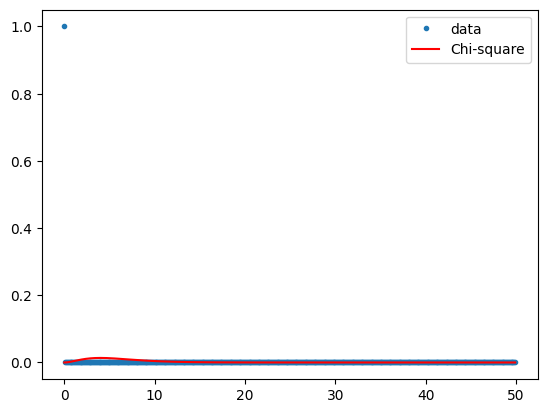

In [32]:
aoi = ee.Geometry.Polygon([[[17.204933,60.402663],[17.204933,60.455525],[17.2645,60.455525],[17.2645,60.402663],[17.204933,60.402663]]])

visirbands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
visbands = ['B2', 'B3', 'B4']
rededgebands = ['B5', 'B6', 'B7', 'B8A']

im1,im2 = collect(aoi,'2017-06-01','2017-10-01','2023-06-01','2023-10-01')
im1 = im1.updateMask(wetlands)
im2 = im2.updateMask(wetlands)

# Re-run MAD.
U, V, MAD, Z = mad_run(im1.select(visirbands), im2.select(visirbands), scale=20)

# Plot histogram of Z.
hist = Z.reduceRegion(ee.Reducer.fixedHistogram(0, 50, 500), aoi, scale=20).get('sum').getInfo()
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.plot(x, y, '.', label='data')
# The chi-square distribution with 6 degrees of freedom.
plt.plot(x, chi2.pdf(x, 6)/10, '-r', label='Chi-square')
plt.legend()
plt.show()

In [33]:
def chi2cdf(Z,df):
    '''Chi-square cumulative distribution function with df degrees of freedom.'''
    return ee.Image(Z.divide(2)).gammainc(ee.Number(df).divide(2))

def imad(current,prev):
    '''Iterator function for iMAD.'''
    done =  ee.Number(ee.Dictionary(prev).get('done'))
    return ee.Algorithms.If(done, prev, imad1(current, prev))

def imad1(current,prev):
    '''Iteratively re-weighted MAD.'''
    image = ee.Image(ee.Dictionary(prev).get('image'))
    Z = ee.Image(ee.Dictionary(prev).get('Z'))
    allrhos = ee.List(ee.Dictionary(prev).get('allrhos'))
    nBands = image.bandNames().length().divide(2)
    weights = chi2cdf(Z,nBands).subtract(1).multiply(-1)
    scale = ee.Dictionary(prev).getNumber('scale')
    niter = ee.Dictionary(prev).getNumber('niter')
    # Weighted stacked image and weighted covariance matrix.
    centeredImage, covarArray = covarw(image, weights, scale)
    bNames = centeredImage.bandNames()
    bNames1 = bNames.slice(0, nBands)
    bNames2 = bNames.slice(nBands)
    centeredImage1 = centeredImage.select(bNames1)
    centeredImage2 = centeredImage.select(bNames2)
    s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
    s22 = covarArray.slice(0, nBands).slice(1, nBands)
    s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
    s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)
    c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
    b1 = s11
    c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
    b2 = s22
    # Solution of generalized eigenproblems.
    lambdas, A = geneiv(c1, b1)
    _, B       = geneiv(c2, b2)
    rhos = lambdas.sqrt().project(ee.List([1]))
    # Test for convergence.
    lastrhos = ee.Array(allrhos.get(-1))
    done = rhos.subtract(lastrhos) \
               .abs() \
               .reduce(ee.Reducer.max(), ee.List([0])) \
               .lt(ee.Number(0.0001)) \
               .toList() \
               .get(0)
    allrhos = allrhos.cat([rhos.toList()])
    # MAD variances.
    sigma2s = rhos.subtract(1).multiply(-2).toList()
    sigma2s = ee.Image.constant(sigma2s)
    # Ensure sum of positive correlations between X and U is positive.
    tmp = s11.matrixDiagonal().sqrt()
    ones = tmp.multiply(0).add(1)
    tmp = ones.divide(tmp).matrixToDiag()
    s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(), [0]).transpose()
    A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
    # Ensure positive correlation.
    tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
    tmp = tmp.divide(tmp.abs()).matrixToDiag()
    B = B.matrixMultiply(tmp)
    # Canonical and MAD variates.
    centeredImage1Array = centeredImage1.toArray().toArray(1)
    centeredImage2Array = centeredImage2.toArray().toArray(1)
    U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames1])
    V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames2])
    iMAD = U.subtract(V)
    # Chi-square image.
    Z = iMAD.pow(2) \
              .divide(sigma2s) \
              .reduce(ee.Reducer.sum())
    return ee.Dictionary({'done': done, 'scale': scale, 'niter': niter.add(1),
                          'image': image, 'allrhos': allrhos, 'Z': Z, 'iMAD': iMAD})

In [34]:
def run_imad(aoi, image1, image2, scale=20, maxiter=100):
    try:
        N = image1.bandNames().length().getInfo()
        imadnames = ['iMAD'+str(i+1) for i in range(N)]
        imadnames.append('Z')
        # Maximum iterations.
        inputlist = ee.List.sequence(1, maxiter)
        first = ee.Dictionary({'done':0,
                            'scale': scale,
                            'niter': ee.Number(0),
                            'image': image1.addBands(image2),
                            'allrhos': [ee.List.sequence(1, N)],
                            'Z': ee.Image.constant(0),
                            'iMAD': ee.Image.constant(0)})
        # Iteration.
        result = ee.Dictionary(inputlist.iterate(imad, first))
        # Retrieve results.
        iMAD = ee.Image(result.get('iMAD')).clip(aoi)
        rhos = ee.String.encodeJSON(ee.List(result.get('allrhos')).get(-1))
        Z = ee.Image(result.get('Z'))
        niter = result.getNumber('niter')
        # Export iMAD and Z as a singe image, including rhos and number of iterations in properties.
        iMAD_export = ee.Image.cat(iMAD, Z).rename(imadnames).set('rhos', rhos, 'niter', niter)
        #assexport = ee.batch.Export.image.toAsset(iMAD_export,
        #                description='assetExportTask',
        #                assetId=assetId, scale=scale, maxPixels=1e10)
        #assexport.start()
        #print('Exporting iMAD to %s\n task id: %s'%(assetId, str(assexport.id)))
    except Exception as e:
        print('Error: %s'%e)
    return iMAD_export

In [35]:
iMAD_export = run_imad(aoi, im1.select(visirbands), im2.select(visirbands))

In [36]:
im_imad = iMAD_export.select(0, 1, 2, 3, 4, 5)
im_z = iMAD_export.select(6).rename('Z')
niter = im_imad.get('niter').getInfo()
rhos = ee.List(im_imad.get('rhos')).getInfo()
print('iteratons: %i'%niter)
print('canonical correlations: %s'%rhos)

iteratons: 2
canonical correlations: [1.000000000000067,1.0000000000000506,1.0000000000000038,0.999999999999995,0.9999999999999905,0.999999999999942]


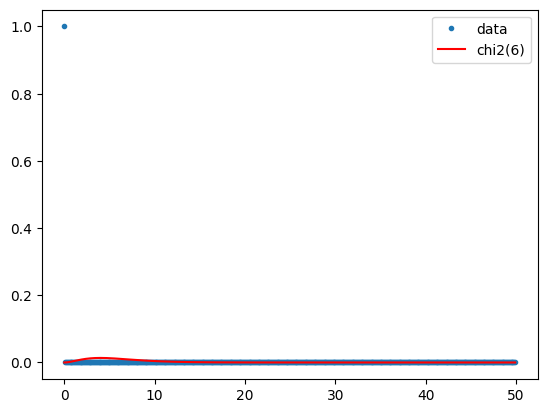

In [37]:
scale = 20
# p-values image.
pval = chi2cdf(im_z, 6).subtract(1).multiply(-1).rename('pval')
# No-change mask (use p-values greater than 0.1).
noChangeMask = pval.gt(0.1)
hist = im_z.updateMask(noChangeMask).reduceRegion(ee.Reducer \
           .fixedHistogram(0, 50, 500), aoi, scale=scale, maxPixels=1e11) \
           .get('Z').getInfo()
a = np.array(hist)
x = a[:, 0]                 # array of bucket edge positions
y = a[:, 1]/np.sum(a[:, 1]) # normalized array of bucket contents
plt.plot(x, y, '.', label = 'data')
plt.plot(x, chi2.pdf(x, 6)/10, '-r', label='chi2(6)')
plt.legend()
plt.show()

In [40]:
M1 = geemap.Map()
M1.centerObject(aoi, 11)
M1.addLayer(im1.select(visbands),{}, 'im1')
M1.addLayer(im2.select(visbands), {}, 'im2')
M1.addLayer(im_imad.select('iMAD1', 'iMAD2', 'iMAD3'),{}, 'iMAD123', True)
M1

Map(center=[60.42909015971474, 17.23471649999347], controls=(WidgetControl(options=['position', 'transparent_b…

In [43]:
# Standardize to no change sigmas.
sigma2s = ee.Image.constant([2*(1-x) for x in eval(rhos)])
im_imadstd = im_imad.divide(sigma2s.sqrt())
im_imadstd = im_imadstd.updateMask(wetlands)
# Collect training data.
training = im_imadstd.sample(region=aoi, scale=scale, numPixels=50000)
# Train the clusterer.
clusterer = ee.Clusterer.wekaKMeans(2).train(training)
# Classify the standardized imad image.
result = im_imadstd.cluster(clusterer)

In [44]:
M2 = geemap.Map()
M2.centerObject(aoi, 13)
M2.addLayer(im2.select(visbands), 'im1')
#display_ls(im2.select(visbands), M2, 'im2')
cluster0 = result.updateMask(result.eq(0))
cluster1 = result.updateMask(result.eq(1))
cluster2 = result.updateMask(result.eq(2))
cluster3 = result.updateMask(result.eq(3))
palette = ['red', 'yellow', 'blue', 'black']
vis_params = {'min': 0, 'max': 3, 'palette': palette}
#M2.addLayer(im1.select(visbands),{'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}, 'im1')
M2.addLayer(cluster0, vis_params, 'new clearcuts')
M2.addLayer(cluster1, vis_params, 'agriculture')
M2.addLayer(cluster2, vis_params, 'prior clearcuts')
#wetlands_contours = wetlands.subtract(wetlands.focalMin(30, 'square', 'meters'))
#M2.addLayer(wetlands_contours.updateMask(wetlands_contours),{'min': 0, 'max': 1, 'palette': ['blue']},'wetlands')
M2.addLayer(cluster3, vis_params, 'no change')

M2

TypeError: vis_params must be a dictionary

In [ ]:
dyn = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
                    .filterDate('2017-06-01', '2023-06-30') \
                    .filterBounds(aoi) \
                    .select('label').mosaic()
# 'trees' class = class 1
dw = dyn.clip(aoi).updateMask(dyn.eq(1))

M3 = geemap.Map()
M3.centerObject(aoi, 13)
display_ls(im1.select(visbands), M3, 'im1')
display_ls(im2.select(visbands), M3, 'im2')
M3.addLayer(dw, {'min': 0, 'max': 1, 'palette': ['black', 'green']}, 'dynamic world')
M3.addLayer(cluster0, vis_params, 'new clearcuts')

M3

Map(center=[60.42909015971474, 17.23471649999347], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
M4 = geemap.Map()
M4.centerObject(aoi, 13)
diff = im1.subtract(im2).select(visirbands)
training = diff.sample(region=aoi, scale=20, numPixels=50000)
clusterer = ee.Clusterer.wekaKMeans(4).train(training)
result1 = diff.cluster(clusterer)
cluster0d = result1.updateMask(result1.eq(0))

display_ls(im1.select(visbands), M4, 'im1')
display_ls(im2.select(visbands), M4, 'im2')
M4.addLayer(cluster0d, {'min': 0, 'max': 3,
                    'palette': ['orange', 'yellow', 'blue', 'black']}, 'clearcuts (diff)')
M4.addLayer(cluster0, vis_params, 'clearcuts (iMAD)')
wetlands_contours = wetlands.subtract(wetlands.focalMin(20, 'square', 'meters'))
M4.addLayer(wetlands_contours.updateMask(wetlands_contours),{'min': 0, 'max': 1, 'palette': ['blue']},'wetlands')
M4

Map(center=[60.42909015971474, 17.23471649999347], controls=(WidgetControl(options=['position', 'transparent_b…